In [1]:
sc

### Recent Followers Tracked

Using the REST API, we tracked new followers of Trump, Clinton, and Sanders over the span of one week. Each minute, we asked Twitter for the followers of each of the three candidates (using different API keys... technically against the terms of service), and we kept track of all known followers for each candidate in a Python set.

We also calculated how new each follower was to Twitter in seconds and injected this data into the user's info. Thus, if a user happened to create an account on Twitter and follow Clinton 10 seconds later, we would identify this no later than 70 seconds after the user joined. We also added a "candidate" field so that we could identify which candidate the user had followed when we went back to look at the aggregate data.

We will now read in the user JSON files and use SparkSQL to query the data.

In [2]:
df = sqlContext.read.json('/home/anaconda/md0/data/2016_potus/users_all')
df.registerTempTable('followers')

## Number of New Followers
How many new followers did each candidate have?

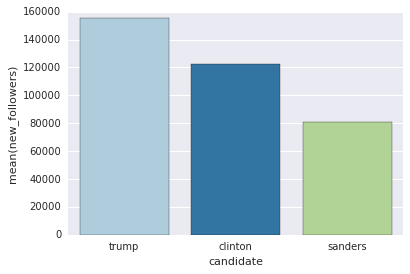

In [5]:
%matplotlib inline 
import seaborn as sns
import matplotlib
import warnings

query = """
select
    candidate, count(*) as new_followers
from followers
group by candidate
"""
dfp = sqlContext.sql(query).toPandas()

sns.barplot(x="candidate", y="new_followers", data=dfp, palette="Paired")

## At First Glance...

It appears that Trump is much more popular on Twitter. He gained nearly twice as many followers in the past week as Sanders, and still significantly more than Clinton gained. What else is going on here?

Let's look at how long those users have had accounts on Twitter at the time they became Trump followers.

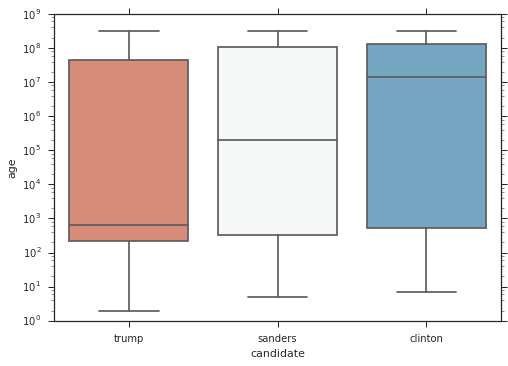

In [14]:
import numpy as np

query = """
select
    candidate as candidate,
    created_at_age as age
from followers
"""
dfp = sqlContext.sql(query).toPandas()

sns.set(style="ticks")

ax = sns.boxplot(x="candidate", y="age", data=dfp, palette="RdBu", whis=np.inf)
ax.set_yscale("log")

## Statuses -vs- Followers -vs- Friends

What are the p50 and p99 values for the numbers of statuses, followers, and friends a user has when the user has followed a candidate within two minutes of joining Twitter?

In [23]:
query = """
select
    candidate,
    percentile(statuses_count, 0.50) as p50_status,
    percentile(statuses_count, 0.99) as p99_status,
    percentile(followers_count, 0.50) as p50_follow,
    percentile(followers_count, 0.99) as p99_follow,
    percentile(friends_count, 0.50) as p50_friend,
    percentile(friends_count, 0.99) as p99_friend,
    count(*) as num
from followers
where created_at_age < 120
group by candidate
"""

sqlContext.sql(query).show()

+---------+----------+----------+----------+----------+----------+------------------+-----+
|candidate|p50_status|p99_status|p50_follow|p99_follow|p50_friend|        p99_friend|  num|
+---------+----------+----------+----------+----------+----------+------------------+-----+
|    trump|       0.0|       1.0|       0.0|       2.0|      30.0|122.94000000000051|15407|
|  clinton|       0.0|       1.0|       0.0|       2.0|      40.0|             100.0| 1804|
|  sanders|       0.0|       1.0|       0.0|       1.0|      40.0|             100.0| 2645|
+---------+----------+----------+----------+----------+----------+------------------+-----+



In [24]:
query = """
select
    candidate,
    percentile(statuses_count, 0.50) as p50_status,
    percentile(statuses_count, 0.99) as p99_status,
    percentile(followers_count, 0.50) as p50_follow,
    percentile(followers_count, 0.99) as p99_follow,
    percentile(friends_count, 0.50) as p50_friend,
    percentile(friends_count, 0.99) as p99_friend,
    count(*) as num
from followers
where created_at_age > 60*60*24
group by candidate
"""

sqlContext.sql(query).show()

+---------+----------+------------------+----------+------------------+----------+------------------+-----+
|candidate|p50_status|        p99_status|p50_follow|        p99_follow|p50_friend|        p99_friend|  num|
+---------+----------+------------------+----------+------------------+----------+------------------+-----+
|    trump|      20.0|23187.800000000032|      18.0| 4256.800000000003|     100.0|3281.4000000000087|61521|
|  clinton|      58.0|32972.759999999995|      35.0| 7352.759999999864|     155.0|3717.5199999999895|77525|
|  sanders|     198.0| 48569.95999999999|      69.0|10504.719999999987|     204.0| 4431.559999999998|41137|
+---------+----------+------------------+----------+------------------+----------+------------------+-----+



In [145]:
query = """
select
    friends_count/created_at_age as friends_per_second,
    floor(created_at_age/60) as minutes_on_twitter
from followers
where created_at_age < 1200
"""
dfp = sqlContext.sql(query).toPandas()

(0, 1)

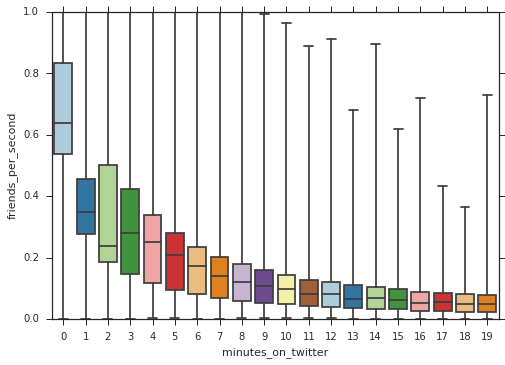

In [147]:
sns.set(style="ticks")

ax = sns.boxplot(x="minutes_on_twitter", y="friends_per_second", data=dfp, palette="Paired", whis=np.inf)
ax.set_ylim(0,1)